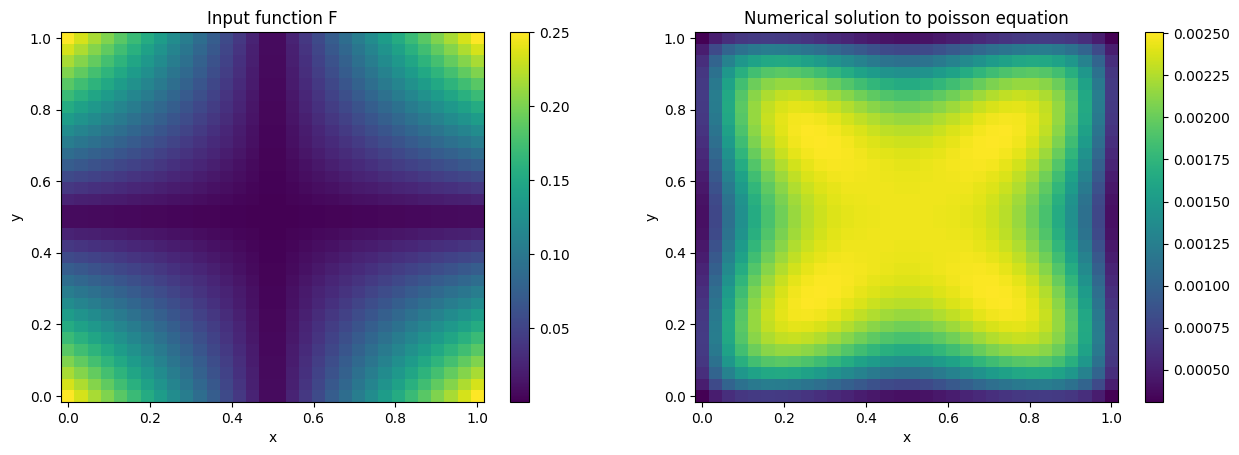

torch.Size([1, 1, 32, 32])


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch

N = 32
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)


#SEE FORM OF OPERATOR IN DATGEN PAPER, SOLVING Lu=-f

neumann = False

# Define f
F = np.abs(X -0.5) * np.abs(Y-0.5)
#F = np.sin(X)*np.sin(Y)/np.sqrt(2*np.pi**2) - np.sin(2*X) * np.sin(Y) / np.sqrt(5*np.pi**2)
# F = X - Y
#F = X**2 + Y**2
#F = X*Y



#redefine for numerical solver, which solves Lu = f, so have to redefine
F_num = -F

#numerical solver 

# Initialize the sparse matrix A
main_diagonal = np.ones(N**2) * -4 / h**2
offset_diagonals = np.ones(N**2 - 1) / h**2
offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
far_diagonals = np.ones(N**2 - N) / h**2

# Create the sparse matrix A using diags
A = sp.diags(
    [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
    [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')

# Apply boundary conditions (zero boundary conditions applied by default)

if neumann:
    print(3)
    for i in range(N):
        if i == 0 or i == N-1:
            A[i,:] = A[-(i+1),:] = 0
            A[i,i] = A[-(i+1),-(i+1)] = 1/h
        if i % N == 0 or (i+1) % N == 0:
            A[i,:] = 0
            A[i,i] = 1/h

F_num = F_num.ravel()

if neumann:
    F_num[0:N] =F_num[-N:] = F_num[::N] = F_num[N-1::N] = 0

# Solve the linear system
u = scipy.sparse.linalg.spsolve(A, F_num)
U = u.reshape((N, N))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,F)
fig.colorbar(fig1)
axs[0].set_title("Input function F")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical solution to poisson equation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()



#save input function

F = torch.tensor(F)[None,None,:]
print(F.shape)
torch.save(F,"../finput.pt")

In [2]:
import torch
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device(type='cuda')

In [3]:

import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO, FNO

from neuralop.training import Trainer 

from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from neuralop.training import CheckpointCallback, BasicLoggerCallback
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.datasets.output_encoder import UnitGaussianNormalizer
from neuralop.datasets.transforms import PositionalEmbedding2D
from neuralop.datasets.data_transforms import DefaultDataProcessor
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

print(device)

cuda


In [4]:
model = FNO(n_modes=(12, 12), hidden_channels=64,in_channels=3,non_linearity=F.relu)
model = model.to(device)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 2803521 parameters.


In [6]:
#load the model if needed
a = 1
if a == 1:
    state_dict = torch.load("checkpoints/checkpoints_working_100000_300_relu_0.5_25_best/model_state_dict.pt")
    model.load_state_dict(state_dict)

In [7]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=25,gamma = 0.5)

# Creating the losses

train_loss = LpLoss(d=2,p=2)

sys.stdout.flush()

In [8]:
#now for the data preparation process, following the darcy code
x_train = torch.load('../data_poisson/dirichlet_10000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('../data_poisson/dirichlet_10000_32_y.pt').clone().type(torch.FloatTensor)
y_train = torch.unsqueeze(y_train,1).to(device)
grid_boundaries=[[0, 1], [0, 1]]


train_db = TensorDataset(
        x_train,
        y_train,
    )


train_loader = torch.utils.data.DataLoader(
        train_db,
        batch_size=100,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        persistent_workers=False,
    )


#this is where the two extra dimensions come from, the postiional encodings
pos_encoding = PositionalEmbedding2D(grid_boundaries=grid_boundaries)

data_processor = DefaultDataProcessor(
        in_normalizer=None,
        out_normalizer=None,
        positional_encoding=pos_encoding
    )
data_processor = data_processor.to(device)

In [9]:
#test set
x_test = torch.load('../data_poisson/dirichlet_test_100_32_x.pt').clone().type(torch.FloatTensor)
y_test = torch.load('../data_poisson/dirichlet_test_100_32_y.pt').clone().type(torch.FloatTensor)

y_test = torch.unsqueeze(y_test,1).to(device)
test_db = TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(
        test_db,
        batch_size=10,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        persistent_workers=False,
    )
test_loader = {"100":test_loader}
eval_loss = {"l2_test": train_loss}

In [14]:
# trainer = Trainer(model=model, n_epochs=31,
#                   device=device,
#                   callbacks=[
#                     CheckpointCallback(save_dir='./checkpoints',
#                                        save_interval=1,
#                                             save_optimizer=True,
#                                             save_scheduler=True)
#                         ],
#                   data_processor=None,
#                   wandb_log=False,
#                   log_test_interval=3,
#                   use_distributed=False,
#                   verbose=True)


from CustomCallback import BasicLoggerCallback2

#callback modified to access loss history
callback = BasicLoggerCallback2()
ckpt = CheckpointCallback(save_dir='./checkpoints',
                                       save_interval=10,
                                            save_optimizer=True, 
                                            save_scheduler=True)
trainer = Trainer(model=model, n_epochs=301,
                  device=device,
                  callbacks=[callback,ckpt],
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=1,
                  use_distributed=False,
                  verbose=True)

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [77]:

trainer.train(train_loader=train_loader,
              test_loaders=test_loader,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=None, 
              training_loss=train_loss,
              eval_losses=eval_loss
              )

Training on 100000 samples
Testing on [100] samples         on resolutions ['100'].
Raw outputs of size out.shape=torch.Size([100, 1, 32, 32])
[0] time=26.30, avg_loss=0.3761, train_err=37.6125, 100_l2_test=0.2875
Successfully saved training state to checkpoints
Saved training state to checkpoints
[1] time=25.61, avg_loss=0.1509, train_err=15.0895, 100_l2_test=0.3153
[2] time=26.40, avg_loss=0.1474, train_err=14.7389, 100_l2_test=0.2985
[3] time=26.43, avg_loss=0.1049, train_err=10.4858, 100_l2_test=0.3040
[4] time=27.31, avg_loss=0.0759, train_err=7.5879, 100_l2_test=0.3055
[5] time=27.18, avg_loss=0.0855, train_err=8.5475, 100_l2_test=0.3072
[6] time=26.92, avg_loss=0.0710, train_err=7.1029, 100_l2_test=0.3014
[7] time=25.96, avg_loss=0.0730, train_err=7.3038, 100_l2_test=0.3047
[8] time=26.29, avg_loss=0.0741, train_err=7.4082, 100_l2_test=0.3054
[9] time=25.10, avg_loss=0.0555, train_err=5.5472, 100_l2_test=0.3298
[10] time=25.15, avg_loss=0.0612, train_err=6.1207, 100_l2_test=0.36

{'100_l2_test': 0.28098887085914614}

ValueError: x and y must have same first dimension, but have shapes (501,) and (301,)

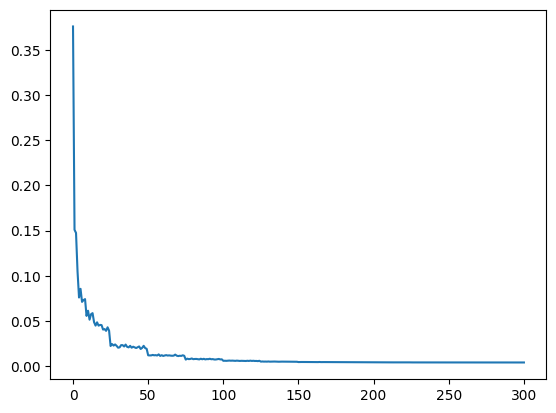

In [85]:
plt.plot(np.arange(0,301,1),callback.loss,"-")
plt.plot(np.arange(0,501,1),callback.val_loss,"-r")
plt.legend()
plt.show()

tensor(0.2606, dtype=torch.float64)


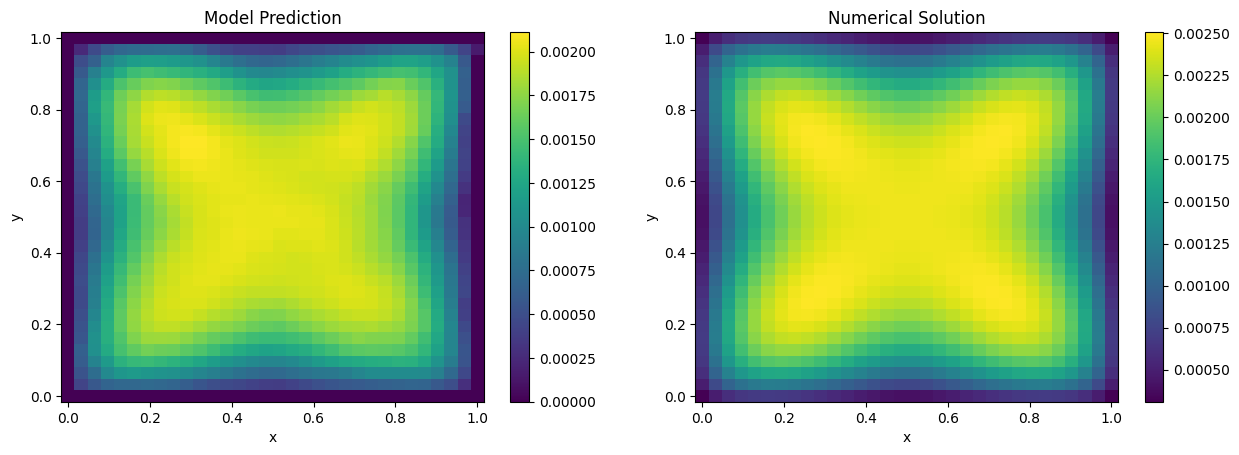

In [15]:
#prediction time
sample = torch.load("../finput.pt").clone().type(torch.FloatTensor).to(device)
sample = {"x": sample, "y": sample}

#preprocessing
sample = data_processor.preprocess(sample)
x = sample["x"]



out = model(x).cpu().detach().numpy()[0,0,:,:]

print(train_loss(torch.tensor(out),torch.tensor(U)))



# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2,gridspec_kw={'width_ratios': [1, 1]})
fig.set_figwidth(15)


#prediction
fig1 = axs[0].pcolormesh(X,Y,out)
fig.colorbar(fig1)
axs[0].set_title("Model Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")


#actual
fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()
